In [42]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
path = './cifar-10-batches-py/'
trainbatch = ['data_batch_'+str(i) for i in range(1, 6)]
testbatch = 'test_batch'

#train
trainlabel = []
traindata = []

for f in trainbatch:
    batch = unpickle(path+f)
    trainlabel.extend(batch[b'labels'])
    traindata.extend(batch[b'data'])

traindata = np.array(traindata)
birdindex, = np.where(np.array(trainlabel)==2)
birdtrain = traindata[birdindex]
birdtrain.shape

batch2 = unpickle(path+testbatch)
testlabel = batch2[b'labels']
testdata = batch2[b'data']

birdindex, = np.where(np.array(testlabel)==2)
birdtest = testdata[birdindex]
birdtest.shape

bird = np.concatenate((birdtrain, birdtest))

In [8]:
bird.shape

(6000, 3072)

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(bird)

In [15]:
def original_data_to_img(row):
    a = []
    pixel_num = len(row)//3
    for i in range(pixel_num):
        red = row[i]
        green = row[i+pixel_num]
        blue = row[i+2*pixel_num]
        a.append(red)
        a.append(green)
        a.append(blue)
    pixels = np.reshape(a, (pixel_num, 3))
    pixels = np.reshape(pixels, (32,32,3))
    return pixels

In [16]:
train_images = []
test_images = []
for i in range(len(birdtrain)):
    train_images.append(original_data_to_img(birdtrain[i]))
for i in range(len(birdtest)):
    test_images.append(original_data_to_img(birdtest[i]))

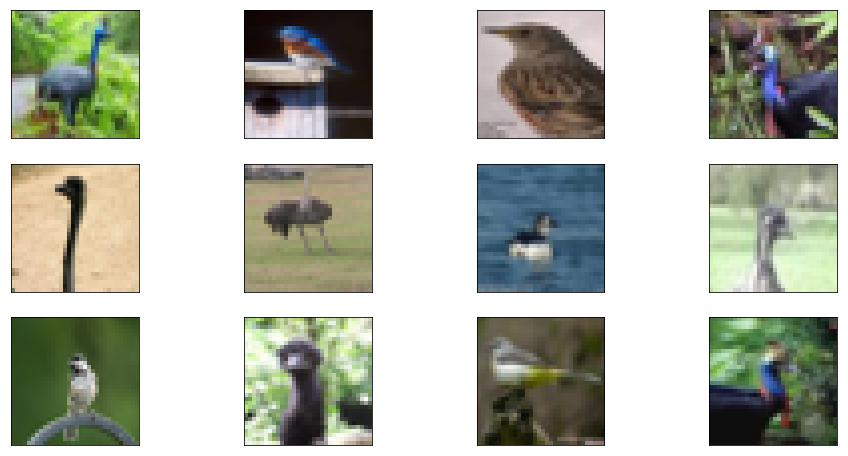

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i in range(12):
    ax = fig.add_subplot(3, 4, 1+i, xticks=[], yticks=[])
    plt.imshow(train_images[i])
plt.show()

In [26]:
main_colors = []
for i in range(len(kmeans.cluster_centers_)):
    main_color_p = [int(round(rgb)) for rgb in kmeans.cluster_centers_[i]]
    main_colors.append(main_color_p)

In [23]:
all_train_pixels = []
for i in range(len(train_images)):
    for j in range(len(train_images[i])):
        for k in range(len(train_images[i][j])):
            all_train_pixels.append(train_images[i][j][k])
all_train_pixels = np.array(all_train_pixels)
all_test_pixels = []
for i in range(len(test_images)):
    for j in range(len(test_images[i])):
        for k in range(len(test_images[i][j])):
            all_test_pixels.append(test_images[i][j][k])
all_test_pixels = np.array(all_test_pixels)

In [24]:
all_pixels = np.concatenate((all_train_pixels, all_test_pixels), axis=0)

In [25]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(all_pixels)

In [27]:
main_color_train_images = []
main_color_train_categories = []
for i in range(len(train_images)):
    main_color_train_image = []
    main_color_train_category = []
    for j in range(len(train_images[i])):
        main_color_train_image_row = []
        main_color_train_category_row = []
        categories = kmeans.predict(train_images[i][j])
        for k in range(len(train_images[i][j])):
            category = categories[k]
            main_color_train_category_row.append(category)
            pixel = main_colors[category]
            main_color_train_image_row.append(pixel)
        main_color_train_image.append(main_color_train_image_row)
        main_color_train_category.append(main_color_train_category_row)
    main_color_train_images.append(main_color_train_image)
    main_color_train_categories.append(main_color_train_category)

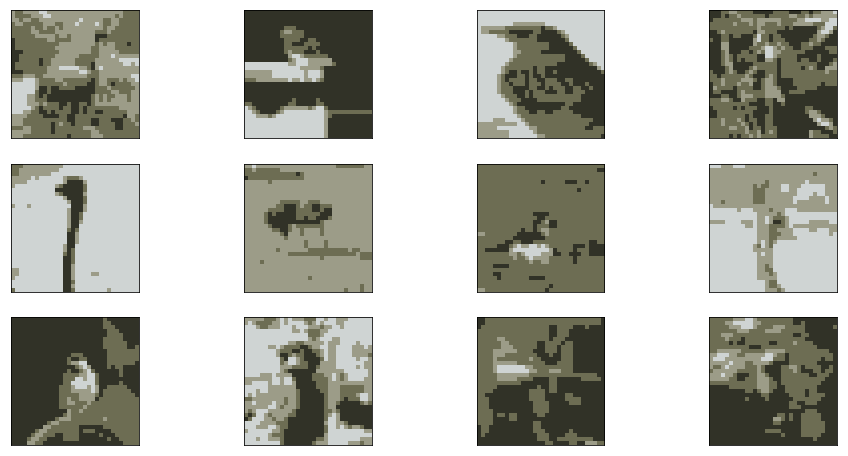

In [28]:
fig = plt.figure(figsize=(16, 8))
for i in range(12):
    ax = fig.add_subplot(3, 4, 1+i, xticks=[], yticks=[])
    plt.imshow(main_color_train_images[i])
plt.show()

In [29]:
from skimage.color import rgb2gray
grayscale_train = []
for i in range(len(train_images)):
    grayscale_train.append(rgb2gray(train_images[i]))

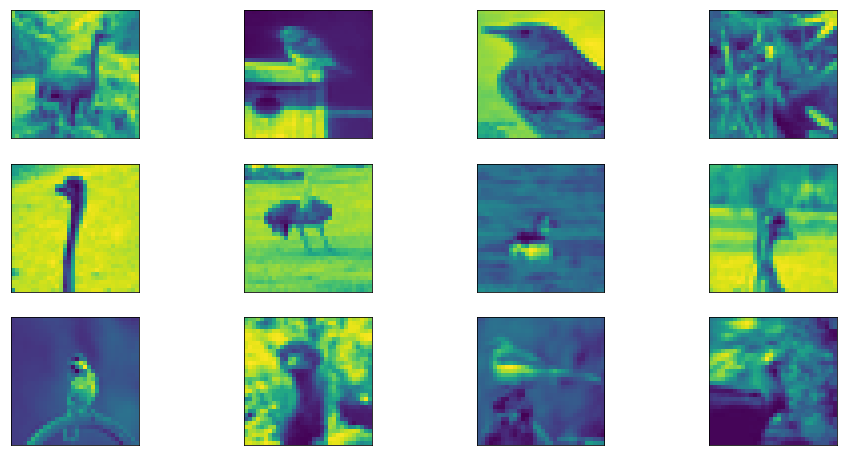

In [30]:
fig = plt.figure(figsize=(16, 8))
for i in range(12):
    ax = fig.add_subplot(3, 4, 1+i, xticks=[], yticks=[])
    plt.imshow(grayscale_train[i])
plt.show()

In [31]:
grayscale_test = []
for i in range(len(test_images)):
    grayscale_test.append(rgb2gray(test_images[i]))

In [32]:
grayscale_train = np.array(grayscale_train)
grayscale_test = np.array(grayscale_test)

In [45]:
grayscale_train_1 = grayscale_train.reshape(5000, 32, 32, 1)
grayscale_test_1 = grayscale_test.reshape(1000, 32, 32, 1)

In [46]:
from keras.utils import to_categorical
train_class_scheme = to_categorical(main_color_train_categories)
train_class_scheme_1 = train_class_scheme.reshape(5000,32,32,4)


In [47]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', input_shape=(32,32,1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))    
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(8192, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Activation('softmax'))

In [48]:
filepath='cnn-epoch-5.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [51]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
Train = model.fit(grayscale_train_1, train_class_scheme_1, validation_split=0.2, 
                            epochs = 5, batch_size=128, verbose=1, callbacks=callbacks_list)

ValueError: Error when checking target: expected activation_3 to have 2 dimensions, but got array with shape (5000, 32, 32, 4)